In [1]:
import os
from os.path import join
import numpy as np
import json
import pickle
from transformers import BertTokenizer
from PIL import Image, ImageOps
import scipy.io
#import cv2
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

/Users/zhuangzhuangdai/opt/anaconda3/envs/egocap/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Latex font
#plt.rc('text', usetex=False)
#plt.rc('font', family='serif')
plt.rcParams["font.family"] = "Times New Roman"

#matplotlib.use('PS')

In [ ]:
amt_data_dir = "/home/zdai/repos/EgoTransformer/Data/amt_data/"
ana_file = join('Data', 'deepdiary_data', 'lifelog', 'dataset.json')
vocab_file = join('Data', 'data', 'vocabulary.p')

## ViT

In [3]:
# Pretrained ViT
from pytorch_pretrained_vit import ViT

#from vit_pytorch import ViT
#from vit_pytorch.extractor import Extractor
from torchvision.models._utils import IntermediateLayerGetter

/Users/zhuangzhuangdai/opt/anaconda3/envs/DLpy37/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/zhuangzhuangdai/opt/anaconda3/envs/DLpy37/lib/python3.7/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZTVN5torch8autograd12AutogradMetaE
  Referenced from: /Users/zhuangzhuangdai/opt/anaconda3/envs/DLpy37/lib/python3.7/site-packages/torchvision/image.so
  Expected in: /Users/zhuangzhuangdai/opt/anaconda3/envs/DLpy37/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


AttributeError: module 'torch.fx' has no attribute 'wrap'

In [1]:
vit_config = dict(hidden_size=512, num_heads=8, num_layers=6)
model = ViT.from_config(vit_config)

NameError: name 'ViT' is not defined

In [18]:
vit = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 3,  #1000,
    dim = 256, #1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048
)

In [20]:
vit

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=256, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=256, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=256, out_features=2048

In [21]:
#vit0 = IntermediateLayerGetter(vit, return_layers={"mlp_head": "0"})
vit0 = IntermediateLayerGetter(vit, return_layers={"transformer": {"layers": {"5": "1"}}})

In [22]:
vit0

IntermediateLayerGetter(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=256, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=256, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=25

## Deepdiary Image-Caption pairs

In [64]:
amt_data_dir = "/Users/zhuangzhuangdai/repos/EgoTransformer/images/amt_data"
ana_file = join(amt_data_dir, 'amt_list.txt')
#vocab_file = join('Data', 'data', 'vocabulary.p')

In [ ]:
with open(ana_file, "r") as file:
    ana = json.load(file)

In [ ]:
ana['images'][0]

In [ ]:
img_305 = []
imgids = []

for img_name in os.listdir(amt_data_dir):
    for img_dict in ana['images']:
        if img_name == img_dict['filename']:
            img_305.append(img_dict)
            imgids.append(img_dict['imgid'])
            
print(len(imgids), len(img_305))

### Use 'amt_list.txt' directly

In [ ]:
with open(ana_file, "r") as file:
    pairs_str = file.read()
    pairs = pairs_str.split('\n')[1:]
len(pairs)

In [ ]:
img_names = {}

for pair in pairs:
    img_name = pair.split(' ')[0]
    sent_ana = pair.split('.jpg ')[-1]
    
    if img_name not in img_names:
        img_names[img_name] = [sent_ana]
    else:
        img_names[img_name].append(sent_ana)
        
len(img_names.items())

In [ ]:
my_idx = 50
for idx, (key, val) in enumerate(img_names.items()):
    if idx == my_idx:
        img_name0, cap_lst0 = key, val
        break

image0 = Image.open(join(amt_data_dir, img_name0))
# Transpose with respect to EXIF data
image0 = ImageOps.exif_transpose(image0)
w, h = image0.size
print("PIL Image width: {}, height: {}".format(w, h))

plt.imshow(image0)
plt.show()
print(cap_lst0)

In [62]:
def get_deepdiary(index, ann_filename):
    with open(ann_filename, "r") as file:
        pairs_str = file.read()
        pairs = pairs_str.split('\n')[1:]
    
    img_names = {}

    for pair in pairs:
        img_name = pair.split(' ')[0]
        sent_ana = pair.split('.jpg ')[-1]

        if img_name not in img_names:
            img_names[img_name] = [sent_ana]
        else:
            img_names[img_name].append(sent_ana)
    
    for idx, (key, val) in enumerate(img_names.items()):
        if idx == index:
            img_name0, cap_lst0 = key, val
            break

    image0 = Image.open(join(amt_data_dir, img_name0))
    # Transpose with respect to EXIF data
    image0 = ImageOps.exif_transpose(image0)
    w, h = image0.size
    print("PIL Image width: {}, height: {}".format(w, h))

    plt.imshow(image0)
    plt.show()
    print(cap_lst0)
    return image0, cap_lst0, img_name0

PIL Image width: 640, height: 480


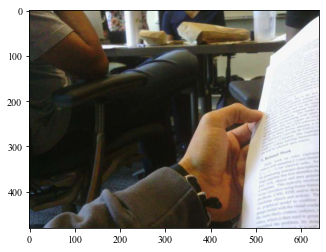

['I am reading a paper.', 'A person is sitting while reading a paper.', 'A person is sitting with other people.']


In [97]:
tuples = get_deepdiary(203, ana_file)

In [104]:
tuples

(<PIL.Image.Image image mode=RGB size=640x480>,
 ['Several trees are located across the street.',
  'Flowers and trees grow in landscaping near a street.',
  'I am relaxing with a beverage in the center of a town, near some plantings and a town square.',
  'A person in the foreground is holding a disposable drink cup.',
  'One can see a nearby intersection of two streets with flower plantings and trees and shrubs nearby.'],
 'bbb255cdfb5c42b0b6638c2aad55abd4.jpg')

## Deepdiary VGG16 features & caption pairs

In [ ]:
diary_data_dir = "/home/zdai/repos/EgoTransformer/Data/deepdiary_data/lifelog"
diary_ann = join(diary_data_dir, 'dataset.json')
diary_data = join(diary_data_dir, 'vgg_feats.mat')

In [ ]:
diary_mat = scipy.io.loadmat(diary_data)
diary_mat.keys()

In [ ]:
diary_mat['feats'][:50, 0]

In [ ]:
diary_mat['feats'].shape

In [ ]:
(diary_mat['feats'][:, -7] == diary_mat['feats'][:, -9]).all()

In [ ]:
with open(diary_ann, "r") as file:
    diary_anns = json.load(file)
len(diary_anns['images'])

In [ ]:
diary_anns['images'][-1]

In [ ]:
diary_pairs = diary_anns['images'].copy()

In [ ]:
index = 0
ann_pairs = []
last_sent0, last_sent_1 = '', ''

for idx, item in enumerate(diary_anns['images']):
    
    if item['sentences'][0]['raw'] == last_sent0 and item['sentences'][-1]['raw'] == last_sent_1:
        diary_pairs[idx]['segment'] = index
        
        tup[0].append(diary_mat['feats'][:, idx])
        
    else:
        last_sent0 = item['sentences'][0]['raw']
        last_sent_1 = item['sentences'][-1]['raw']
        
        if idx != 0:
            ann_pairs.append(tup)
            del tup
        
        index += 1
        diary_pairs[idx]['segment'] = index
        
        # tuple of (vgg_feature_vec, [captions])
        caps = [sent['raw'] for sent in item['sentences']]
        tup = ([diary_mat['feats'][:, idx]], caps)
    
    diary_pairs[idx]['feats'] = diary_mat['feats'][:, idx]

In [ ]:
ann_pairs[-1]

In [ ]:
with open(join(diary_data_dir, 'diary_pairs.pkl'), 'wb') as a_file:
    pickle.dump(diary_pairs, a_file)

In [ ]:
### Loading ###
with open(join(diary_data_dir, 'diary_pairs.pkl'), 'rb') as a_file:
    diary_pairs = pickle.load(a_file)

In [ ]:
with open(join(diary_data_dir, 'ann_pairs.pkl'), 'wb') as a_file:
    pickle.dump(ann_pairs, a_file)

In [ ]:
### Loading ###
with open(join(diary_data_dir, 'ann_pairs.pkl'), 'rb') as a_file:
    ann_pairs = pickle.load(a_file)

In [ ]:
ann_pairs[-1]

## MSVD

In [ ]:
msvd_data_dir = "/home/zdai/repos/MSVD"
msvd_ana_file = join(msvd_data_dir, 'AllVideoDescriptions.txt')
skipped_dir = join(msvd_data_dir, 'skipped')

In [ ]:
pairs = []

with open(msvd_ana_file, "r") as file:
    lines = file.readlines()
    print("Num of lines = ", len(lines))
    for line in lines:
        if line != "\n" and line[0] != "#":
            pairs.append(line)
len(pairs)

In [ ]:
vid_anns = {}
min_frame_per_clip = 5

for pair in pairs:
    img_name = pair.split(' ')[0]
    sent_ana = pair[len(img_name) + 1:-1]
    
    if img_name not in vid_anns:
        # Create a list of [path_to_image]
        img_keys = []
        # Discard clip with less than N frames
        if len(os.listdir(join(skipped_dir, img_name))) < min_frame_per_clip:
            continue
        
        for frame in sorted(os.listdir(join(skipped_dir, img_name)), key=lambda x: int(x.split('.')[0][6:])):
            #print(frame)
            img_keys.append(join(skipped_dir, img_name, frame))
        #show_img(img_keys[0])
        
        vid_anns[img_name] = (img_keys, [sent_ana])
    else:
        if sent_ana in vid_anns[img_name][1]:
            continue
        vid_anns[img_name][1].append(sent_ana)
        
len(vid_anns)

In [ ]:
def show_img(path_to_img):
    image0 = Image.open(path_to_img)
    # Transpose with respect to EXIF data
    image0 = ImageOps.exif_transpose(image0)
    w, h = image0.size
    print("PIL Image width: {}, height: {}".format(w, h))

    plt.imshow(image0)
    plt.show()

In [ ]:
vid_anns

In [ ]:
Anns = []

for idx, (key, val) in enumerate(vid_anns.items()):
    for index in range(len(val[1])):
        for i in range(len(val[0]) - min_frame_per_clip + 1):
            tuple_item = (val[0][i:i + min_frame_per_clip], val[1][index])
            Anns.append(tuple_item)

len(Anns)

In [ ]:
# Exhaustive selection
import random
window_frame_per_clip = 5
Anns_train, Anns_test = [], []

In [ ]:
X_train, X_test = train_test_split(list(vid_anns.keys()), test_size=0.3, random_state=123, shuffle=True)

for idx, (key, val) in enumerate(vid_anns.items()):
    
    for i in range(len(val[0]) - window_frame_per_clip + 1):
        
        tuple_item = (val[0][i:i + window_frame_per_clip], random.choice(val[1]))
        # Split vid_anns based on whether vid_name in X_train/X_test lists
        if key in X_train:
            Anns_train.append(tuple_item)
        elif key in X_test:
            Anns_test.append(tuple_item)
            
        # Break to avoid sample too many from long clips
        if i > 15:
            break

In [ ]:
print(len(Anns_train), len(Anns_test))

In [ ]:
len(Anns)

### Load with Function

In [ ]:
from sklearn.model_selection import train_test_split

def read_msvd(msvd_ana_file, skipped_dir, min_frame_per_clip=7, window_frame_per_clip=5):
    # TODO: split MSVD into train / test
    pairs, Anns_train, Anns_test = [], [], []
    vid_anns = {}
    
    assert window_frame_per_clip <= min_frame_per_clip

    with open(msvd_ana_file, "r") as file:
        lines = file.readlines()
        print("Num of lines = ", len(lines))
        for line in lines:
            if line != "\n" and line[0] != "#":
                pairs.append(line)

    for pair in pairs:
        img_name = pair.split(' ')[0]
        sent_ana = pair[len(img_name) + 1:-1]

        if img_name not in vid_anns:
            # Create a list of [path_to_image]
            img_keys = []
            # Discard clip with less than N frames
            if len(os.listdir(join(skipped_dir, img_name))) < min_frame_per_clip:
                continue

            for frame in sorted(os.listdir(join(skipped_dir, img_name)), key=lambda x: int(x.split('.')[0][6:])):
                img_keys.append(join(skipped_dir, img_name, frame))

            vid_anns[img_name] = (img_keys, [sent_ana])
        else:
            if sent_ana in vid_anns[img_name][1]:
                continue
            vid_anns[img_name][1].append(sent_ana)
    
    # vid_anns is a dict of {'vid_name': (['img1.jpg', 'img2.jpg' ...], ['cap1', 'cap2' ...]), ... ...}
    #print(next(iter(vid_anns)))
    X_train, X_test = train_test_split(list(vid_anns.keys()), test_size=0.3, random_state=42, shuffle=True)

    for idx, (key, val) in enumerate(vid_anns.items()):
        for index in range(len(val[1])):
            for i in range(len(val[0]) - window_frame_per_clip + 1):
                tuple_item = (val[0][i:i + window_frame_per_clip], val[1][index])
                # Split vid_anns based on whether vid_name in X_train/X_test lists
                if key in X_train:
                    Anns_train.append(tuple_item)
                elif key in X_test:
                    Anns_test.append(tuple_item)

    return Anns_train, Anns_test

In [ ]:
msvd_data_dir = "/home/zdai/repos/MSVD"
msvd_ana_file = join(msvd_data_dir, 'AllVideoDescriptions.txt')
skipped_dir = join(msvd_data_dir, 'skipped')

In [ ]:
anns_train, anns_test = read_msvd(msvd_ana_file, skipped_dir, min_frame_per_clip=7, window_frame_per_clip=5)
print(len(anns_train), len(anns_test))

In [ ]:
# anns_ is a list of tuple (['path/to/img1.jpg', 'path/to/img2.jpg' ...], 'A dog is sitting')
anns_test[-1]

# EgoCap

In [4]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey/doc'
egocap_filename = 'analyzed_annatations.json'

In [22]:
with open(join(egocap_dir, egocap_filename), 'r') as f:
    ana = json.load(f)

In [23]:
len(ana)

2079

In [24]:
# Reference labels
ego4d_dir = '/Users/zhuangzhuangdai/ego4d_data'
with open(join(ego4d_dir, 'ego4d.json')) as f:
    ref_ego4d = json.load(f)
    
coco_dir = '/Users/zhuangzhuangdai/repos/EgoTransformer/images/annotations'
with open(join(coco_dir, 'captions_val2017.json')) as f:
    ref_coco = json.load(f)
    
msvd_dir = '/Users/zhuangzhuangdai/repos/MSVD/'
with open(join(msvd_dir, 'AllVideoDescriptions.txt')) as f:
    ref_msvd = f.readlines()
    
msrvtt_dir = '/Users/zhuangzhuangdai/repos/MSRVTT/train_val_annotation'
with open(join(msrvtt_dir, 'train_val_videodatainfo.json')) as f:
    ref_msrvtt = json.load(f)
    
# MSRVTT Category
with open(join(msrvtt_dir, 'category.txt')) as f:
    ref_msrvtt_cat = f.readlines()

In [29]:
### Add reference labels from original {COCO, Ego4D, MSVD, MSRVTT} datasets ###
def update_ann_reference(ann, ref, ref_co, ref_vd=None, ref_vtt=None, ref_vtt_cat=None):
    
    for idx, (key, val) in enumerate(ann.items()):
        filename = None
        try:
            # For image name parsing
            key_lst = key.split('.')
            #print(key_lst[0], len(key_lst))
            
            if len(key_lst) == 3 and key_lst[1] == "avi00001":
                # MSVD
                filename = key_lst[0]
                if ref_vd is not None:
                    for video_item in ref_vd:
                        if video_item.startswith(filename):
                            labels = video_item[len(filename) + 1:-1]
                            ann[key]['reference'] = {
                                'origin': 'MSVD',
                                'labels': [labels]
                            }
                            break
            
            elif len(key_lst) == 3 and key_lst[1] == "mp400001":
                # MSRVTT
                if ref_vtt is not None:
                    for video_item in ref_vtt['videos']:
                        filename = key_lst[0]
                        if video_item['video_id'] == filename:
                            cat_num = int(video_item['category'])
                            labels = ref_vtt_cat[cat_num].split('\t')[0]
                            ann[key]['reference'] = {
                                'origin': 'MSRVTT',
                                'labels': [labels]
                            }
            
            else:
                key_lst = key.split('.')[0].split('_')
                if len(key_lst) == 1:
                    # COCO
                    filename = key_lst[0]
                    cap_lst = []
                    for video_item in ref_co['annotations']:
                        if str(video_item['image_id']).zfill(12) == filename:
                            cap_lst.append(video_item['caption'])

                    ann[key]['reference'] = {
                                'origin': 'coco_val2017',
                                'labels': cap_lst
                            }
                
                elif len(key_lst) == 2:
                    # Ego4D
                    filename = key_lst[0]

                    for video_item in ref['videos']:
                        if video_item['video_uid'] == filename:
                            labels = video_item['scenarios']
                            ann[key]['reference'] = {
                                'origin': 'Ego4D',
                                'labels': labels
                            }
                            break
                        else:
                            ann[key]['reference'] = {
                                'origin': 'Ego4D',
                                'labels': []
                            }
                    
                else:
                    raise KeyError("Source image name invalid/non-exist!")
            
        except:
            raise TypeError("Not an image with reference!")
            
    return ann

In [30]:
new_ana = update_ann_reference(ana, ref_ego4d, ref_coco, ref_msvd, ref_msrvtt, ref_msrvtt_cat)

In [31]:
# Export "analyzed_annatations_ref"
with open(join(egocap_dir, 'EgoCap_annatations_ref.json'), 'w', encoding='utf-8') as f:
    json.dump(new_ana, f, ensure_ascii=False, indent=4)

### EgoCap Analysis

In [3]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey/doc'

In [4]:
# Load "analyzed_annatations_ref"
with open(join(egocap_dir, 'EgoCap_annatations_ref.json'), 'r') as f:
    ana = json.load(f)

In [5]:
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

def tagger(string):
    PEOPLE_ONLY, OBJ_ONLY, PEOPLE_OBJ, DOING = False, False, False, False
    text = nltk.word_tokenize(string)
    taggers = nltk.pos_tag(text)
    
    tags = [item[1] for item in taggers]
    if ('PRP' in tags or 'PRP$' in tags or 'NNP' in tags or 'NNPS' in tags) and ('NN' not in tags and 'NNS' not in tags):
        PEOPLE_ONLY = True
            
    if ('PRP' not in tags or 'PRP$' not in tags or 'NNP' not in tags or 'NNPS' not in tags) and ('NN' in tags and 'NNS' in tags):
        OBJ_ONLY = True
        
    if ('PRP' in tags or 'PRP$' in tags or 'NNP' in tags or 'NNPS' in tags) and ('NN' in tags and 'NNS' in tags):
        PEOPLE_OBJ = True
            
    if 'VB' in tags or 'VBG' in tags:
        DOING = True
        
    return PEOPLE_ONLY, OBJ_ONLY, PEOPLE_OBJ, DOING

In [6]:
people_only, obj_only, people_obj, doing = 0,0,0,0
people_others = 0

for idx, (key, val) in enumerate(ana.items()):
    #print(key)
    sent = val['reference']['labels']
    
    if len(sent) > 0:
        tuples = tagger(sent[0])
        if tuples[0]:
            people_only += 1
            
        if tuples[1]:
            obj_only += 1
        if tuples[2]:
            people_obj += 1
        if tuples[3]:
            doing += 1
            for sentence in sent:
                if 'see' in sentence or 'watch' in sentence or 'look' in sentence or 'man' in sentence or 'lady' in sentence or 'girl' in sentence or 'boy' in sentence or 'baby' in sentence:
                    people_others += 1

In [7]:
people_only, obj_only, people_obj, doing, people_others

(45, 388, 160, 1142, 303)

In [8]:
total = 2079

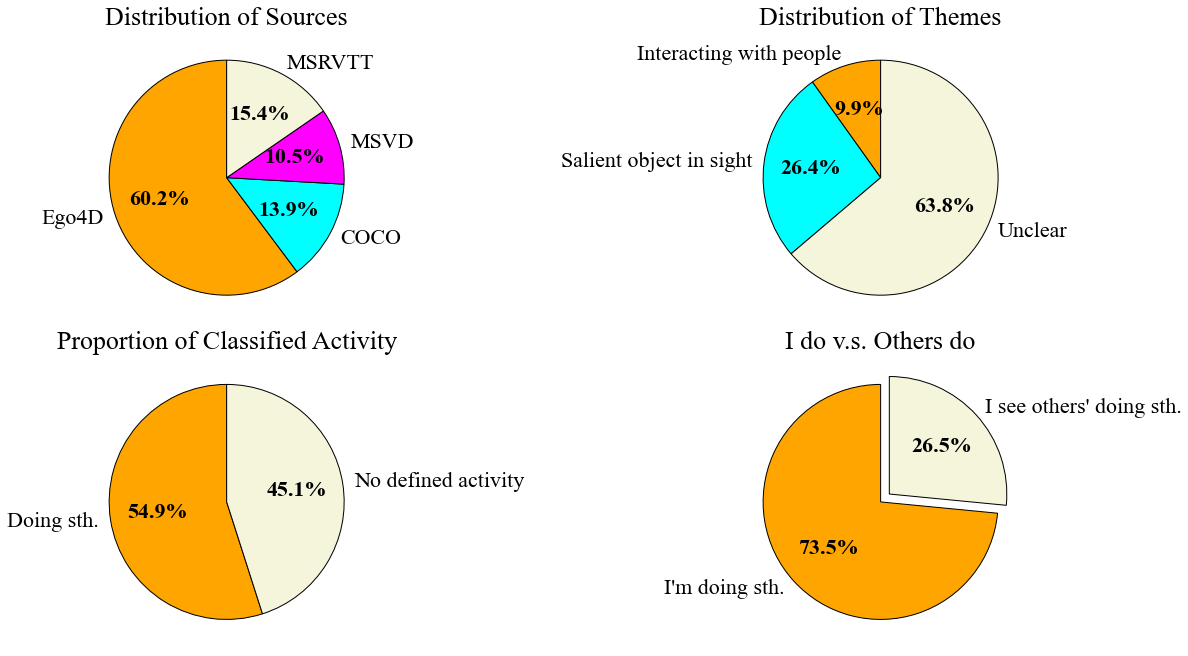

In [11]:
names0 = ['Ego4D', 'COCO', 'MSVD', 'MSRVTT']
data0 = [1252, 289, 218, 320]
explode0 = (0.0, 0.0, 0.0, 0.0)
colors0 = ( "orange", "cyan", "magenta", "beige")

# Creating dataset
names = ['Interacting with people', 'Salient object in sight', 'Unclear']
data = [people_only + people_obj, obj_only + people_obj, total - people_only - obj_only - 2*people_obj]

# Creating explode data
explode = (0.0, 0.0, 0.0)

# Creating color parameters
colors = ( "orange", "cyan", "beige")

# Wedge properties
wp = { 'linewidth' : 1., 'edgecolor' : "black" }


names2 = ["Doing sth.", "No defined activity"]
data2 = [doing, total-doing]
explode2 = (0.0, 0.0)
colors2 = ( "orange", "beige" )

names4 = ["I'm doing sth.", "I see others' doing sth."]
data4 = [doing - people_others, people_others]
explode4 = (0.0, 0.1)
colors4 = ( "orange", "beige" )


# Creating autocpt arguments
def func(pct, allvalues):
	absolute = int(pct / 100.*np.sum(allvalues))
	return "{:.1f}%".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(2, 2, figsize =(18, 9), constrained_layout=True)

wedges, texts, autotexts = ax[0,0].pie(data0,
								autopct = lambda pct: func(pct, data0),
								explode = explode0,
								labels = names0,
								shadow = False,
								colors = colors0,
								startangle = 90,
								wedgeprops = wp,
								textprops = dict(color ="black", fontsize=22))
ax[0,0].set_title("Distribution of Sources", fontsize=26)
plt.setp(autotexts, size = 22, weight ="bold")
'''
ax[0].set_xticks(range(len(data0)), names0, fontsize=18)
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of Images', fontsize=18)
ax[0].set_title("Distribution of Sources", fontsize=24)
ax[0].bar(range(len(data0)), data0) 
'''

wedges, texts, autotexts = ax[0,1].pie(data,
								autopct = lambda pct: func(pct, data),
								explode = explode,
								labels = names,
								shadow = False,
								colors = colors,
								startangle = 90,
								wedgeprops = wp,
								textprops = dict(color ="black", fontsize=22))
ax[0,1].set_title("Distribution of Themes", fontsize=26)
plt.setp(autotexts, size = 22, weight ="bold")

wedges, texts, autotexts = ax[1,0].pie(data2,
								autopct = lambda pct: func(pct, data2),
								explode = explode2,
								labels = names2,
								shadow = False,
								colors = colors2,
								startangle = 90,
								wedgeprops = wp,
								textprops = dict(color ="black", fontsize=22))
ax[1,0].set_title("Proportion of Classified Activity", fontsize=26)
plt.setp(autotexts, size = 22, weight ="bold")

wedges, texts, autotexts = ax[1,1].pie(data4,
								autopct = lambda pct: func(pct, data4),
								explode = explode4,
								labels = names4,
								shadow = False,
								colors = colors4,
								startangle = 90,
								wedgeprops = wp,
								textprops = dict(color ="black", fontsize=22))
ax[1,1].set_title("I do v.s. Others do", fontsize=26)
plt.setp(autotexts, size = 22, weight ="bold")

# Adding legend
#ax.legend(wedges, cars, title ="Cars", loc ="center left", bbox_to_anchor =(1, 0, 0.5, 1))


# show plot
fig.savefig(join('images','pdf',"pie_egocap3.pdf"), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

# MODEL EVAL

In [3]:
from configuration import Config, ConfigEgo
from Eval import predict_qualitative
from pycocoevalcap.bleu.bleu import Bleu, BleuScorer
from pycocoevalcap.meteor.meteor import Meteor, METEOR_JAR
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider, CiderScorer
from pycocoevalcap.spice.spice import Spice, SPICE_JAR

def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        #(Meteor(), "METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr"),
        #(Spice(), "SPICE")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores

In [4]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey'
egocap_filename = 'EgoCap_annatations_ref.json'

with open(join(egocap_dir, 'doc', egocap_filename), 'r') as f:
    ana = json.load(f)

In [5]:
len(ana)

2079

In [6]:
ana[next(iter(ana))]

{'SplitIndex': 18,
 'captions': ['I am walking outside.',
  'I see a woman in a park.',
  'I am walking in the park.',
  'I am in a park on a sunny day.',
  'i am in a park.'],
 'tags': {'where': ['outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor'],
  'what_activity': ['na', 'na', 'na', 'na', 'na'],
  'when': ['daytime', 'daytime', 'daytime', 'daytime', 'daytime'],
  'who': ['human', 'na', 'na', 'na', 'object']},
 'reported': 'False',
 'cap_similarity': {'Bleu_1': 0.5841005870115037,
  'Bleu_2': 0.5506953146048907,
  'Bleu_3': 0.4906137498333178,
  'Bleu_4': 9.792901389423636e-05,
  'ROUGE_L': 0.5791139240506329,
  'CIDEr': 0.0},
 'tag_stats': {'where': {'majority': 'outdoor',
   'percentage': 1.0,
   'total_options': 1},
  'what_activity': {'majority': 'na', 'percentage': 1.0, 'total_options': 1},
  'when': {'majority': 'daytime', 'percentage': 1.0, 'total_options': 1},
  'who': {'majority': 'na', 'percentage': 0.6, 'total_options': 3}},
 'REPORTED': 'False',
 'reference': {'origin

In [7]:
config_t = Config()
config_ego = ConfigEgo()

baseline = '13 - finetune-epoch29_loss15.pth'  #'finetune-best_epoch19_loss15.pth'
egotrans = 'EgoFormer/EgoFormer2-best_epoch33_loss10.pth'

#egotrans_backbone_grad = 'finetuneContextFuse-epoch21_loss10.pth'
#egotrans_freezeencoder = '10 - finetuneContextFuse-epoch19_loss15.pth'

trans_concat = 'EgoFormer/EgoFormerConcat-smallLR-best_epoch19_loss10.pth'
trans_gatedinfo = 'EgoFormer/GatedViT_smallLR-best_epoch19_loss10.pth'

egotrans_prefuse = 'EgoFormer/EgoFormer-PreFuse-smallLR-best_epoch20_loss10.pth'
egotrans_contextembed = '16 - contextembed -finetuneEgoTrans-best_epoch50_loss25.pth'
egotrans_contextfuse = 'finetuneEgoTrans-best_epoch17_loss10.pth'
egotrans_backbonegrad = 'EgoFormer/EgoFormer-BackboneWithGrad-best_epoch19_loss10.pth'
egotrans_encodernograd = 'EgoFormer/EgoFormer-FrontendNoGrad-best_epoch20_loss10.pth'
egotrans_blind = 'EgoFormer/EgoFormer-BlindContext-best_epoch21_loss10.pth'

In [102]:
# Prompt image
sample_name = '0f4e630b-e834-4ff4-9418-ccfdbdc4ee37_small.jpg'

split_idx = str(ana[sample_name]['SplitIndex']).zfill(2)
sample_path = join(egocap_dir, 'static', 'Split' + split_idx, sample_name)
tags = (ana[sample_name]['tag_stats']['where']['majority'], ana[sample_name]['tag_stats']['when']['majority'])

In [103]:
base_dict = predict_qualitative(config_t, sample_path, tags=None, checkpoint_path=baseline)

Loading Checkpoint...
Current checkpoint epoch = 29
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.26s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 480, height: 360

I am watching a group of people playing cards.



In [104]:
cap_dict = predict_qualitative(config_ego, sample_path, tags=tags, checkpoint_path=egotrans)

Loading Checkpoint...
Current checkpoint epoch = 33
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.23s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 480, height: 360

I am in a living room with other people.



In [105]:
gts = {sample_name: ana[sample_name]['captions']}
print(gts)

{'0f4e630b-e834-4ff4-9418-ccfdbdc4ee37_small.jpg': ['I am with a group of people indoor.', 'I am with people in a living room.', 'I am having fun with two men and a woman in a living room.', 'I am working with my friends in the living room.', 'I see a woman sitting on the sofa while two men standing beside her.']}


In [ ]:
# Quantatitive Eval
base_metrics = calc_scores(gts, base_dict)
cap_metrics = calc_scores(gts, cap_dict)
print(base_metrics, cap_metrics)

### Qualitative

In [106]:
# Load Image
image = Image.open(sample_path)
# Transpose with respect to EXIF data
image = ImageOps.exif_transpose(image)
w, h = image.size
print("PIL Image width: {}, height: {}".format(w, h))

PIL Image width: 480, height: 360


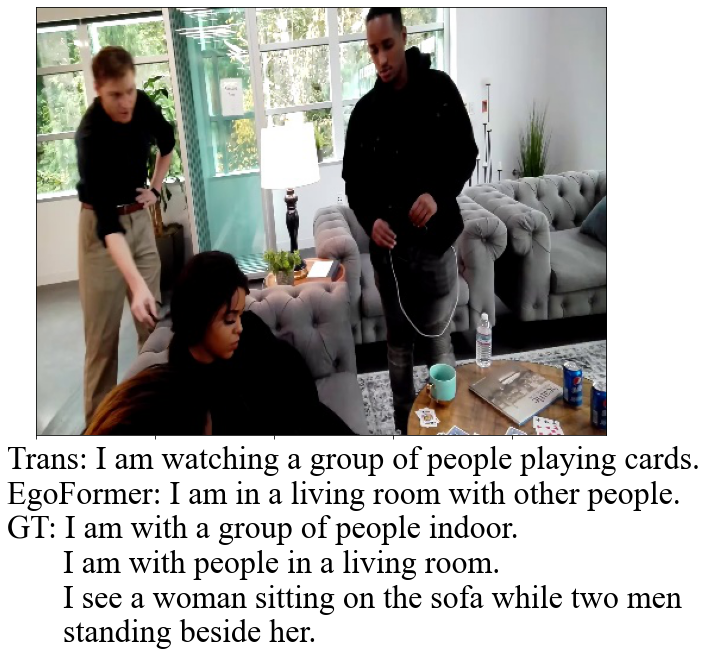

In [110]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 9), constrained_layout=True)

ax.set_xlabel("Trans: " + base_dict[sample_name][0].capitalize() +
              '\n' + "EgoFormer: " + cap_dict[sample_name][0].capitalize() +
              '\n' + "GT: " + gts[sample_name][0].capitalize() +
              '\n' + "       " + gts[sample_name][1].capitalize() +
              '\n' + "       " + 'I see a woman sitting on the sofa while two men \n       standing beside her.',#gts[sample_name][4].capitalize(),
              fontsize=32, horizontalalignment='left', x=-0.05,
              #fontdict=dict(weight='bold')
             )

plt.imshow(image)
#ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().get_yaxis().set_visible(False)

fig.savefig(join('images', 'EgoFormer2', sample_path.split("/")[-1]), facecolor='w', bbox_inches='tight')

plt.show()

PIL Image width: 640, height: 480


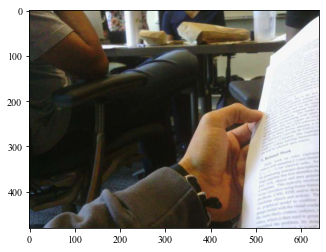

['I am reading a paper.', 'A person is sitting while reading a paper.', 'A person is sitting with other people.']


In [98]:
### Load DeepDiary samples ###
amt_data_dir = "/Users/zhuangzhuangdai/repos/EgoTransformer/images/amt_data"
diary_file = join(amt_data_dir, 'amt_list.txt')

diary_tuple = get_deepdiary(203, diary_file)  # 93, 
sample_path = join(amt_data_dir, diary_tuple[2])

In [99]:
base_dict = predict_qualitative(config_t, sample_path, tags=None, checkpoint_path=baseline)

Loading Checkpoint...
Current checkpoint epoch = 29
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.31s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 640, height: 480

I am reading a book.



In [100]:
cap_dict = predict_qualitative(config_ego, sample_path, tags=None, checkpoint_path=egotrans)

Loading Checkpoint...
Current checkpoint epoch = 33
Initializing Device: cpu
Loading pretrained Tokenizer takes: 3.27s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 640, height: 480

I am sitting in a room.



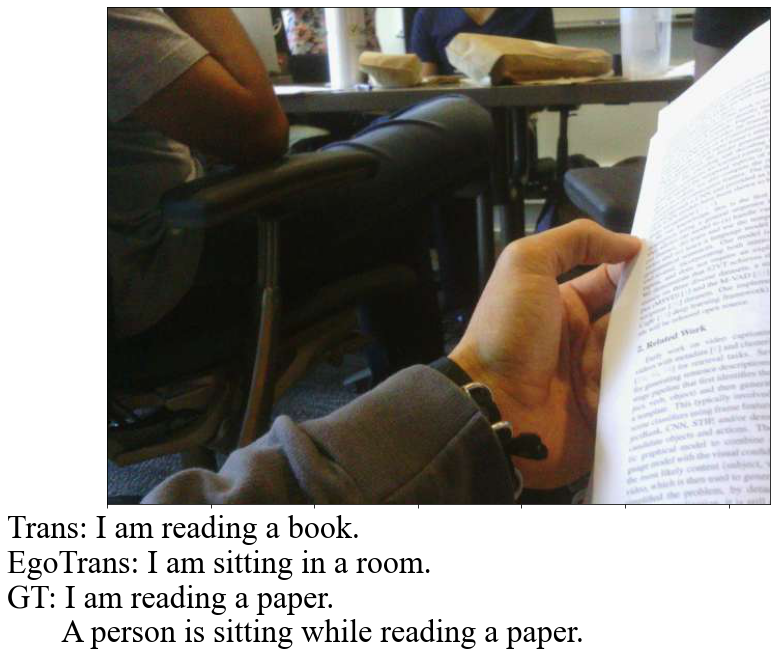

In [101]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 9), constrained_layout=True)

ax.set_xlabel("Trans: " + base_dict[next(iter(base_dict))][0].capitalize() +
              '\n' + "EgoTrans: " + cap_dict[next(iter(cap_dict))][0].capitalize() +
              '\n' + "GT: " + diary_tuple[1][0] +
              '\n' + "       " + diary_tuple[1][1],
              #'\n' + "      " + diary_tuple[1][2],
              fontsize=32, horizontalalignment='left', x=-0.15,
              #fontdict=dict(weight='bold')
             )

plt.imshow(diary_tuple[0])
#ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().get_yaxis().set_visible(False)

fig.savefig(join('images', 'deepdiary2', diary_tuple[2]), facecolor='w', bbox_inches='tight')

plt.show()

### Quantitative

In [111]:
eval_split = ['03', '10', '17']

config_t = Config()
config_ego = ConfigEgo()

baseline = '13 - finetune-epoch29_loss15.pth'  #'finetune-best_epoch19_loss15.pth'
egotrans = 'EgoFormer/EgoFormer2-best_epoch33_loss10.pth'

trans_concat = 'EgoFormer/EgoFormerConcat-smallLR-best_epoch19_loss10.pth'
trans_gatedinfo = 'EgoFormer/GatedViT_smallLR-best_epoch19_loss10.pth'

egotrans_prefuse = 'EgoFormer/EgoFormer-PreFuse-smallLR-best_epoch20_loss10.pth'
egotrans_contextembed = '16 - contextembed -finetuneEgoTrans-best_epoch50_loss25.pth'
egotrans_contextfuse = 'finetuneEgoTrans-best_epoch17_loss10.pth'
egotrans_backbonegrad = 'EgoFormer/EgoFormer-BackboneWithGrad-best_epoch19_loss10.pth'
egotrans_encodernograd = 'EgoFormer/EgoFormer-FrontendNoGrad-best_epoch20_loss10.pth'
egotrans_blind = 'EgoFormer/EgoFormer-BlindContext-best_epoch21_loss10.pth'
# egotrans_raw is obtained through loading ImageNet pretrained ViT params directly


In [112]:
def Loop_quantitative_eval(config, checkpoint, annotations, split_lst, egocap_dir_path='/Users/zhuangzhuangdai/repos/EgoCapSurvey'):
    hypo = {}
    refs = {}
    sample_path_lst, tags_lst = [], []
    
    for split in split_lst:
        for idx, (key, val) in enumerate(annotations.items()):
            if int(split) == int(val['SplitIndex']):
                sample_name = key
                sample_path = join(egocap_dir_path, 'static', 'Split' + split.zfill(2), sample_name)
                
                if config.modality == 'ego':
                    tags = (val['tag_stats']['where']['majority'], val['tag_stats']['when']['majority'])
                else:
                    tags = None
                    
                sample_path_lst.append(sample_path)
                tags_lst.append(tags)
                
                ref = {sample_name: val['captions']}
                refs.update(ref)
                
    # Inference with lists of sample_path & tags
    pred_dict = predict_qualitative(config, sample_path_lst, tags_lst, checkpoint_path=checkpoint)
    hypo.update(pred_dict)
                
    metrics = calc_scores(refs, hypo)
    print(metrics)
    return hypo, refs, metrics

def quantitative_eval(config, checkpoint, annotations, split_lst, egocap_dir_path='/Users/zhuangzhuangdai/repos/EgoCapSurvey'):
    hypo = {}
    refs = {}
    for split in split_lst:
        for idx, (key, val) in enumerate(annotations.items()):
            if int(split) == int(val['SplitIndex']):
                sample_name = key
                sample_path = join(egocap_dir_path, 'static', 'Split' + split.zfill(2), sample_name)
                
                if config.modality == 'ego':
                    tags = (val['tag_stats']['where']['majority'], val['tag_stats']['when']['majority'])
                else:
                    tags = None
                
                ref = {sample_name: val['captions']}
                refs.update(ref)
                # Inference
                pred_dict = predict_qualitative(config, sample_path, tags=tags, checkpoint_path=checkpoint)
                hypo.update(pred_dict)
                
    metrics = calc_scores(refs, hypo)
    print(metrics)
    return hypo, refs, metrics

In [271]:
%%capture
tuples0 = Loop_quantitative_eval(config_t, baseline, ana, eval_split)

In [272]:
print("Baseline Transformer eval report: ", tuples0[2])

Baseline Transformer eval report:  {'Bleu_1': 0.6262773722623166, 'Bleu_2': 0.47318020272109124, 'Bleu_3': 0.3606130569960994, 'Bleu_4': 0.27231778341755175, 'ROUGE_L': 0.5360609543037741, 'CIDEr': 0.8961059109423658}


In [113]:
%%capture
tuples2 = Loop_quantitative_eval(config_ego, egotrans, ana, eval_split)

In [114]:
print("EgoFormer eval report: ", tuples2[2])

EgoFormer eval report:  {'Bleu_1': 0.6543711311947304, 'Bleu_2': 0.5213743973283095, 'Bleu_3': 0.41709896158338367, 'Bleu_4': 0.3246145482358901, 'ROUGE_L': 0.5712747104393757, 'CIDEr': 1.0204332867933585}


In [14]:
%%capture
tuples3 = Loop_quantitative_eval(config_ego, egotrans_backbonegrad, ana, eval_split)

In [15]:
print("EgoFormer_backbonegrad eval report: ", tuples3[2])

EgoFormer_backbonenograd eval report:  {'Bleu_1': 0.6454699698028451, 'Bleu_2': 0.5075489960586107, 'Bleu_3': 0.39644006745355065, 'Bleu_4': 0.30806819649164424, 'ROUGE_L': 0.557553283451505, 'CIDEr': 0.9647525119144503}


In [16]:
%%capture
tuples4 = Loop_quantitative_eval(config_ego, egotrans_encodernograd, ana, eval_split)

In [17]:
print("EgoFormer_encodernograd eval report: ", tuples4[2])

EgoFormer_encodergrad eval report:  {'Bleu_1': 0.652902167624918, 'Bleu_2': 0.5203457772851204, 'Bleu_3': 0.42307067109293406, 'Bleu_4': 0.3373228164547654, 'ROUGE_L': 0.5620731321397279, 'CIDEr': 0.9547540926813717}
